In [1]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import pickle
from scipy.stats import chi2_contingency
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [2]:
# Function to wrangle the dataset
def wrangle(path):
    """
    Preprocesses a dataset from an Excel file located at the given 'path'.

    Parameters:
    path (str): The file path to the Excel dataset.

    Returns:
    df(DataFrame): Processed DataFrame with categorical column conversion and feature engineering applied.
    """
    # Reading the dataset into pandas dataframe
    df = pd.read_excel(path,sheet_name='Data')
    # Selecting columns whose datatype is to be converted to categorical as per the data dictionary
    cats = df.drop(columns=['DURATION','AMOUNT','INSTALL_RATE','AGE','NUM_CREDITS','NUM_DEPENDENTS'])
    # Converting the selected columns to categorical datatype
    for var in cats.columns:
        df[var] = df[var].astype('category')
    # Applying feature engineering to reduce dimensionality
    df['CONSUMER_GOODS'] = df[['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO/TV']].sum(axis=1) 
    df['EDUCATION_CATEGORY'] = df[['EDUCATION', 'RETRAINING']].sum(axis=1)
    
    # Drop features used to generate new ones and that with high cardinality
    df.drop(['NEW_CAR', 'USED_CAR', 'FURNITURE', 'RADIO/TV', 'EDUCATION', 'RETRAINING','OBS#'], axis=1, inplace=True)

    return df
    

In [3]:
# Locating the downloaded excel dataset
file_path = r"C:\Users\llubowa\Downloads\Case Study Sample.xlsx"

In [4]:
# Reading the downloaded excel file into pandas dataframe using the above created function
df = wrangle(file_path)

C:\Users\llubowa\AppData\Local\Temp\ipykernel_20580\1501586284.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


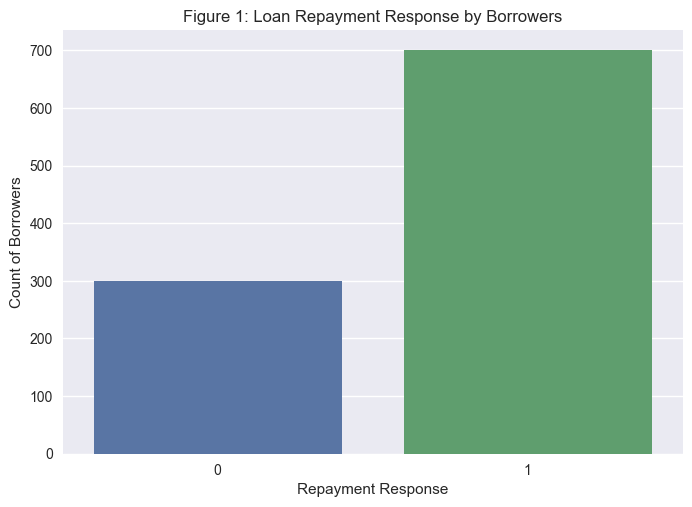

In [5]:
# Investigating our target variable
style.use('seaborn')
sns.countplot(data=df, x='RESPONSE')
plt.title('Figure 1: Loan Repayment Response by Borrowers')
plt.ylabel('Count of Borrowers')
plt.xlabel('Repayment Response');


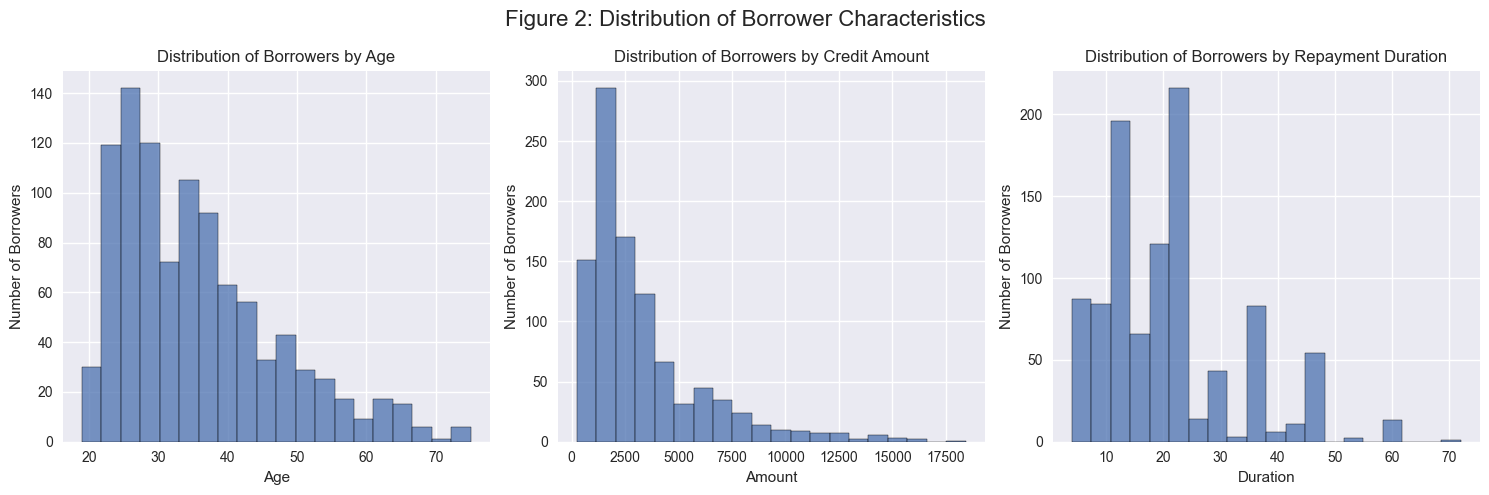

In [6]:
# Figure investigating the numerical features
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms using Seaborn on each subplot
sns.histplot(data=df, bins=20, x='AGE', ax=ax[0])
sns.histplot(data=df, bins=20, x='AMOUNT', ax=ax[1])
sns.histplot(data=df, bins=20, x='DURATION', ax=ax[2])

# Set labels and titles
plt.suptitle("Figure 2: Distribution of Borrower Characteristics", fontsize=16)
ax[0].set_ylabel('Number of Borrowers')
ax[1].set_ylabel('Number of Borrowers')
ax[2].set_ylabel('Number of Borrowers')
ax[0].set_xlabel('Age')
ax[1].set_xlabel('Amount')
ax[2].set_xlabel('Duration')
ax[0].set_title("Distribution of Borrowers by Age")
ax[1].set_title("Distribution of Borrowers by Credit Amount")
ax[2].set_title("Distribution of Borrowers by Repayment Duration")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

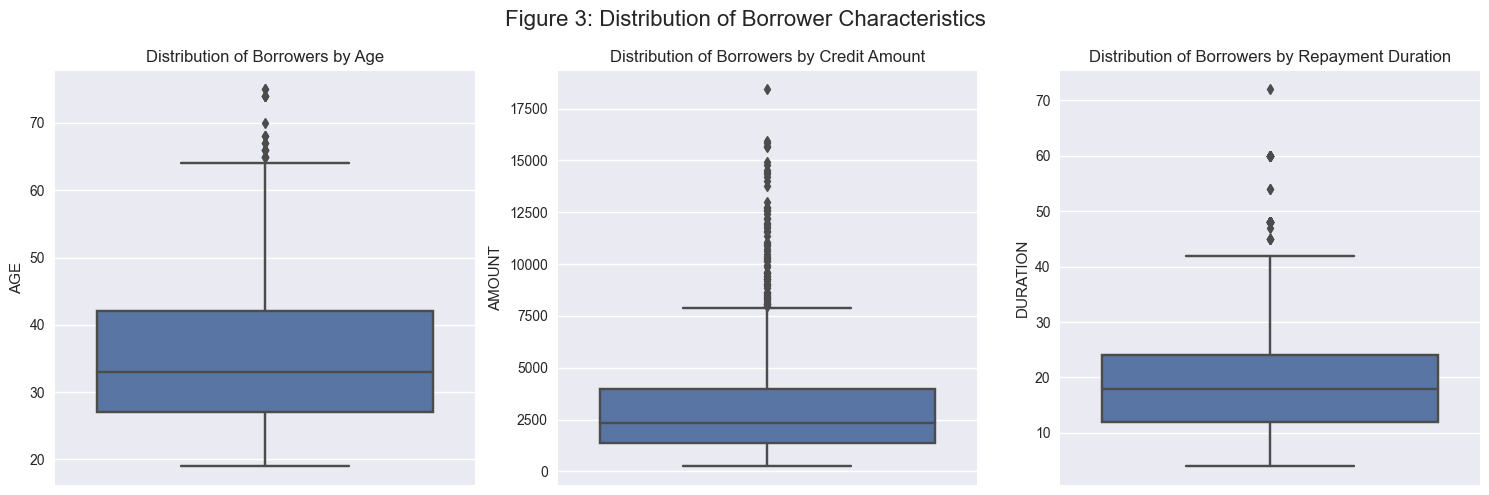

In [7]:
# Figure investigating the numerical features
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Ploting boxplots using Seaborn on each subplot
sns.boxplot(data=df, y='AGE', ax=ax[0])
sns.boxplot(data=df, y='AMOUNT', ax=ax[1])
sns.boxplot(data=df, y='DURATION', ax=ax[2])

# Set labels and titles
plt.suptitle("Figure 3: Distribution of Borrower Characteristics", fontsize=16)
ax[0].set_title("Distribution of Borrowers by Age")
ax[1].set_title("Distribution of Borrowers by Credit Amount")
ax[2].set_title("Distribution of Borrowers by Repayment Duration")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


From figure 2 and 3 above, the variables Age, Amount and Duration are skewed to the right with outliers

In [8]:
# Investigating the relationship categorical features and the target Variable
# selecting the categorical features
categorical_columns=df.select_dtypes('category').columns.drop("RESPONSE")
# creating a function to calculate the chi square test on the categorical variables
def chi_square_test(data, var1,var2):
    """
    Conducts a chi-square test for independence between two categorical variables.

    Parameters:
    data (pandas.DataFrame): The DataFrame containing the data.
    var1 (str): The name of the first categorical variable.
    var2 (str): The name of the second categorical variable.

    Returns:
    tuple: A tuple containing the chi-square test statistic and the corresponding p-value.
    """
    # Generating the contingency table for two categorical features
    contingency_table = pd.crosstab(data[var1],data[var2])
    # Obtaining the Chi square and the p-values for the dependence between the two variables
    chi2,p,dof,expected = chi2_contingency(contingency_table)
    return chi2,p

# Calculating the chi-square test between the categorical feature and the RESPONSE (target)
chi_square_results = {}

for var in categorical_columns:
    chi2, p = chi_square_test(df, var, 'RESPONSE')
    # Adding the Chi-square statistic and the p-value to the chi_square_results dictionary
    chi_square_results[var] = {'chi2':chi2,'p_value':p}

# Sorting the categorical features according to their importance
sorted_results = sorted(chi_square_results.items(), key=lambda x: x[1]['p_value'])

for var, result in sorted_results:
    print(f"{var}: chi2 = {result['chi2']}, p-value = {result['p_value']}")


CHK_ACCT: chi2 = 123.72094351626559, p-value = 1.2189020722893845e-26
HISTORY: chi2 = 61.691396964595505, p-value = 1.279187295675096e-12
SAV_ACCT: chi2 = 36.098928192418704, p-value = 2.761214238568249e-07
OWN_RES: chi2 = 17.470703945382763, p-value = 2.9176928238124755e-05
PROP_UNKN_NONE: chi2 = 15.061967189626756, p-value = 0.00010403852314250658
REAL_ESTATE: chi2 = 13.659702407998498, p-value = 0.00021910622249086866
OTHER_INSTALL: chi2 = 12.206068657681561, p-value = 0.0004763430798236829
EMPLOYMENT: chi2 = 18.3682738466968, p-value = 0.0010454523491402541
RENT: chi2 = 8.089071814328515, p-value = 0.004453296372143891
MALE_SINGLE: chi2 = 6.159816487799175, p-value = 0.013068476586913557
FOREIGN: chi2 = 5.82157591503386, p-value = 0.015830754902852868
CO-APPLICANT: chi2 = 3.2748011079097825, p-value = 0.0703514534965371
GUARANTOR: chi2 = 2.5125191264431788, p-value = 0.1129452553900503
MALE_DIV: chi2 = 2.030075187969925, p-value = 0.1542129779461507
TELEPHONE: chi2 = 1.172558531020

From the above: The chi-square test assessed categorical feature significance for 'RESPONSE'. Lower p-values indicate stronger evidence that the feature is related to the response. For instance, 'CHK_ACCT' significantly relates, as p-value is tiny (1.22e-26).

From the above,

C:\Users\llubowa\AppData\Local\Temp\ipykernel_20580\3419530193.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


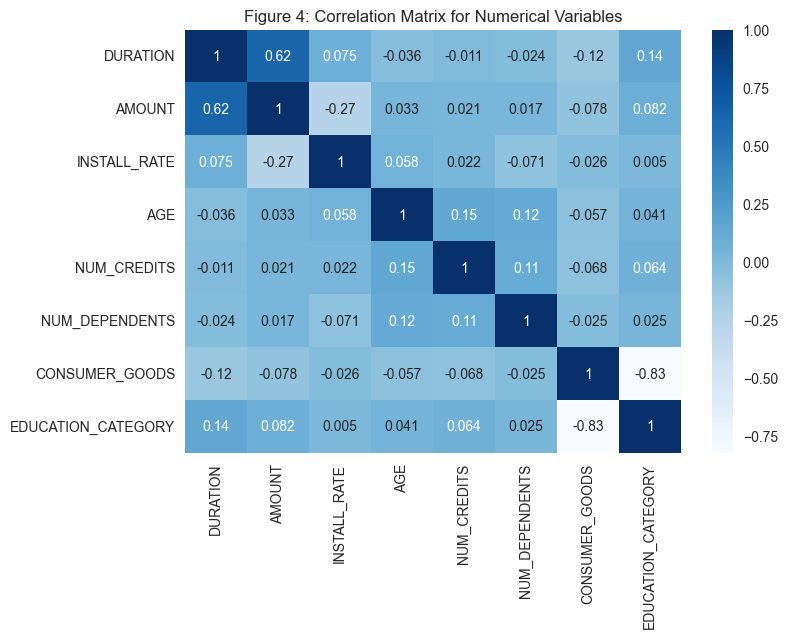

In [9]:
#Calculating the relationship between the numerical features
correlation = df.corr()
#Graphical representation of the numerical relationship between numerical features
sns.heatmap(correlation,annot=True,cbar=True,cmap='Blues')
plt.title('Figure 4: Correlation Matrix for Numerical Variables')
plt.show()


MODEL DEVELOPMENT

In [10]:
#Transforming the Numerical Features to remove skewness and Outliers
transform =['AMOUNT','AGE','DURATION']
for variable in transform:
    df[variable] = np.log(df[variable])

In [11]:
#Instantiating the Model
model = GradientBoostingClassifier(random_state=42)

In [12]:
#Selecting the target and Features to train the model
target = 'RESPONSE'
features = df.columns.drop(target)
#Creating the Feature and Target Matrices
X = df[features]
y = df[target]
#Splitting the Data into Training and Test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
# Fitting the model to the training data
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

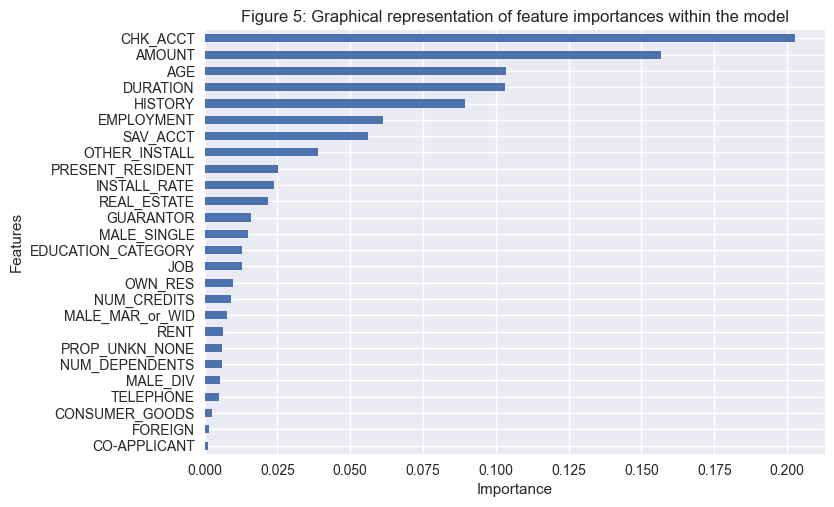

In [13]:
# Obtaining feature importances from the model
feature_names =X_train.columns
importances = model.feature_importances_
# Joining feature names and importances into a serie
featature_importances = pd.Series(importances,index=feature_names).sort_values()
# Displaying the first 12 features
featature_importances.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Figure 5: Graphical representation of feature importances within the model');

From figure 5, the 5 most predictive variables are;
CHK_ACCT,
AMOUNT,
AGE,
DURATION,
HISTORY.

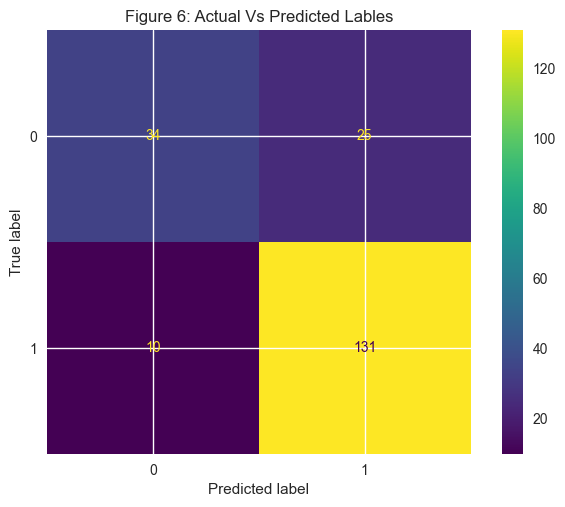

In [14]:
# Testing the model on test data
y_prediction = model.predict(X_test)
# Assessing model performance on the test data
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)
plt.title('Figure 6: Actual Vs Predicted Lables');

In [15]:
# Displaying the classification report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.58      0.66        59
           1       0.84      0.93      0.88       141

    accuracy                           0.82       200
   macro avg       0.81      0.75      0.77       200
weighted avg       0.82      0.82      0.82       200



In [16]:
# Saving the model as 'score_card.pkl'
with open('score_card.pkl','wb') as file:
    pickle.dump(model,file)

In [39]:
# Creating a function which uses our model to make predictions on the new data
def score_card(path):
    '''
    Uses the model to make predictions on a new dataset and saves the results to a CSV file
    Parameter:
    path(str): path to the excel file of new customers to be classified

    Returns:
    None
    '''
    df_unwrangled = pd.read_excel(path,sheet_name='Sheet1')
    # Wrangling the data frame
    df= wrangle(path)
    # Log transformation of features
    transform =['AMOUNT','AGE','DURATION']
    for variable in transform:
        df[variable] = np.log(df[variable])

    # Reading the saved model
    with open('score_card.pkl','rb') as file:
        loaded_model = pickle.load(file)
    predictions = loaded_model.predict(df)
    # Matching the predictions to the customer IDs
    Results = pd.Series(predictions,name="RESPONSE",index=df_unwrangled["OBS#"])
    output = pd.DataFrame(Results)
    # Saving the output to a CSV file 
    output.to_csv('Score_card_response.csv')

In [ ]:
# Calling the function to make predictions on the new datata
'''User must replace the statement "path_to_the_new_dataset.xlsx" with the path to the new excel dataset '''
score_card('path_to_the_new_dataset.xlsx')

1) Data Validation

No duplicate entries were found in the dataset during data entry verification.
All columns were devoid of missing values.
Data types of variables were aligned with the data dictionary, converting integers and binaries to their respective categorical types.
AGE, DURATION, and AMOUNT columns exhibited right-skewed distribution with outliers. Employed log transformation to address outliers.
The PRESENT_RESIDENT variable's categories (1, 2, 3, 4) differed from the data description (0, 1, 2, 3).
The RESPONSE distribution was imbalanced: "Yes" (1) Credit rating had significantly higher count than "No" (0), indicating skewed classes.